# Pytorch and XGBoost Classification (without distributed computing)

The notebook below demonstrates a typical single-PC approach to image classification tasks in both XGBoost and PyTorch. 

We will use these results as a benchmark of sorts against which we can compare the distributed computing methods we would use with very large datasets. 

Without prolonged access to a proper GPU cluster, fair comparisons of processing speed gains will not be possible -- however, we can still take note of the differences in approach whenever they arise, and draw reasonable conclusions about the likely effects of those differences.

RESOURCES AND CITATIONS

[PyImageSearch](https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/)

[Prof. Chinmay Hegde](https://github.com/chinmayhegde/dl-demos/)

[RasterIO](https://rasterio.readthedocs.io/en/latest/)

DATASETS

[Ground-level Fire](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-fire-detection/keras-fire-detection.zip)

[FLAME UAV Aerial Fire](https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs)

[LANDSAT-8 Active Fire](https://ieee-dataport.org/open-access/large-scale-dataset-active-fire-detectionsegmentation-landsat-8#files)

# Setup

These cells must be run first, and should be run before attempting to run any of the classification cells below.

Note also that you will need to adjust the PATH variables to point to your own copies of the datasets -- links to the datasets used are available in the cell above.

In [1]:
%%capture
!pip install rasterio ipython-autotime
%load_ext autotime

time: 1.7 ms (started: 2021-12-01 03:33:38 +00:00)


In [2]:
import warnings
warnings.filterwarnings("ignore")

time: 2.12 ms (started: 2021-12-01 03:33:38 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.72 ms (started: 2021-12-01 03:33:38 +00:00)


# XGBoost Setup (run me first)

XGBoost is an extremely popular library on Kaggle, and is frequently the weapon of choice for classification tasks in machine learning. It uses what is today considered a slightly 'retro' technique called [gradient boosted trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). Although the approach isn't novel, it is extremely powerful for several reasons --

1. It is explainable: it's very easy to see why an XGBoost model is making the decisions it is making
2. It is fast: boosted trees are a lot more efficient than many of the massive, complex model architectures which dominate today's research.
3. It is flexible: XGBoost can handle most tabular-format data with ease. Its interface is based on the well-known sklearn family of libraries, which is familiar to many in data science. And it's very straightforward to use techniques like k-fold cross-validation.

Last but not least, at least not for our purposes, XGBoost is tightly integrated with Dask, making it an ideal candidate for distributed computing experiments. 

In [4]:
import cv2
import rasterio
from rasterio.plot import show
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time
from imutils import paths
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import numpy as np
import imutils
import random
import cv2
import sys
import os

time: 881 ms (started: 2021-12-01 01:48:40 +00:00)


# Image Classification: XGBoost, Ground-Level Fire Imagery

**DATASET NOTES**

The dataset we’ll be using for fire and smoke examples was curated by PyImageSearch reader, Gautam Kumar.

Guatam gathered a total of 1,315 images by searching Google Images for queries related to the term “fire”, “smoke”, etc.

However, the original dataset has not been cleansed of extraneous, irrelevant images that are not related to fire and smoke (i.e., examples of famous buildings before a fire occurred).

Fellow PyImageSearch reader, David Bonn, took the time to manually go through the fire/smoke images and identify ones that should not be included.

The dataset we’ll be using for Non-fire examples is called 8-scenes as it contains 2,688 image examples belonging to eight natural scene categories (all without fire).

The images are in RGB colorspace, JPEG format, with 256x256 resolution.

The image classes are imbalanced in favor of non-fire samples, reflecting the distribution of data we would expect to encounter in the real world.

## Setup

Since XGBoost expects tabular data, we will treat each pixel as a feature. This approach loses all contextual information, of course -- XGBoost's classifier isn't going to be able to learn the same visual feature and apply it to different areas of the image, as the PyTorch classifiers will. For that reason, we should expect somewhat poorer accuracy from XGBoost, but better speed and explainability.

In [ ]:
class Config:
    # initialize the path to the fire and non-fire dataset directories
    FIRE_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/Robbery_Accident_Fire_Database2",
        "Fire"])
    NON_FIRE_PATH = "/content/drive/MyDrive/datasets/spatial_envelope_256x256_static_8outdoorcategories"
    
    # initialize the class labels in the dataset
    CLASSES = ["Non-Fire", "Fire"]

    # define the size of the training and testing split
    TRAIN_SPLIT = 0.75
    TEST_SPLIT = 0.25
    MAX_SAMPLES = 1300
    
    # define the initial learning rate, batch size, and number of epochs
    INIT_LR = .01
    BATCH_SIZE = 64
    NUM_EPOCHS = 50

    # set the path to the serialized model after training
    MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "fire_detection.model"])
    
    # define the path to the output learning rate finder plot and
    # training history plot
    LRFIND_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "lrfind_plot.png"])
    TRAINING_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "training_plot.png"])

    # define the path to the output directory that will store our final
    # output with labels/annotations along with the number of images to
    # sample
    OUTPUT_IMAGE_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "examples"])
    SAMPLE_SIZE = 50

# initialize the configuration object
config = Config()

In [ ]:
def load_dataset(datasetPath, shape, max_samples):
  # grab the paths to all images in our dataset directory, then
  # initialize our lists of images
  imagePaths = list(paths.list_images(datasetPath))
  data = []

  # loop over the image paths, limiting size of dataset to 1300 samples per class
  count = 0
  for imagePath in tq.tqdm(imagePaths):
    count += 1
    # if count > max_samples:
    #   print("breaking at {}".format(max_samples))
    #   break
    # ignoring aspect ratio
    image = cv2.imread(imagePath)
    # load the image and resize it to be a fixed 128x128 pixels
    image = cv2.resize(image, (128, 128))
    if shape == "row":
      image = np.asarray(image).flatten()
    # add the image to the data lists
    data.append(image)

  # return the data list as a NumPy array
  np_data = np.array(data, dtype="float32")
  # Scale to [0,1]
  np_data /= 255
  return np_data

## Train, Test

In [ ]:
%%time
# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH, "row", config.MAX_SAMPLES)
nonFireData = load_dataset(config.NON_FIRE_PATH, "row", config.MAX_SAMPLES)
# stack the fire data with the non-fire data
data = np.vstack([fireData, nonFireData])
labels_np = np.hstack([np.ones((fireData.shape[0],)), np.zeros((nonFireData.shape[0],))])

[INFO] loading data...


  0%|          | 0/1315 [00:00<?, ?it/s]

breaking at 1300


  0%|          | 0/2688 [00:00<?, ?it/s]

breaking at 1300
CPU times: user 48.9 s, sys: 4.41 s, total: 53.3 s
Wall time: 22min


In [ ]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels_np,
	test_size=config.TEST_SPLIT, random_state=24, shuffle=True)

In [ ]:
start_time = time.time()

# fit a Xgboost model to the data
# TODO: optimize params, learning rate, save model weights
model = xgb.XGBClassifier()

cv_results = cross_val_score(model, trainX, trainY, 
                cv = 2, scoring='accuracy', n_jobs = -1, verbose = 1)    

model.fit(trainX, trainY, verbose=True)

print(); print("XGB_Classifier accuracy is {}, {}".format(cv_results[0], cv_results[1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.8min finished



XGB_Classifier accuracy is 0.7856410256410257, 0.7723076923076924


In [ ]:
# make predictions
expected_y = testY
predicted_y = model.predict(testX)

# summarize the fit of the model
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))

print()
print("Execution Time %s seconds: " % (time.time() - start_time)) 


              precision    recall  f1-score   support

         0.0       0.80      0.83      0.81       329
         1.0       0.81      0.78      0.80       321

    accuracy                           0.80       650
   macro avg       0.81      0.80      0.80       650
weighted avg       0.81      0.80      0.80       650


[[272  57]
 [ 70 251]]

Execution Time 688.5248305797577 seconds: 


# Image Classification: XGBoost, LANDSAT-8 Imagery

**DATASET NOTES**

This dataset was created from all Landsat-8 images from South America in the year 2018. More than 31 thousand images were processed (15 TB of data), and approximately on half of them active fire pixels were found.

The images in our dataset are in TIFF (geotiff) format with 10 bands (excluding the 15m panchromatic band). We cropped the original Landsat-8 scenes into image patches with 128 x 128 pixels by using a stride overlap of 64 pixels (vertical and horizontal). The masks are in binary format where True (1) represents fire and False (0) represents background and they were generated from the conditions set by Schroeder et al. (2016). 

## Setup

In [ ]:
class Config:
    # initialize the path to the fire and non-fire dataset directories
    FIRE_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/landsat_mini/Training",
        "Fire"])
    NON_FIRE_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/landsat_mini/Training", "No_Fire"])
    
    # initialize the class labels in the dataset
    CLASSES = ["Non-Fire", "Fire"]

    # define the size of the training and testing split
    TRAIN_SPLIT = 0.75
    TEST_SPLIT = 0.25
    MAX_SAMPLES = 1300
    
    # define the initial learning rate, batch size, and number of epochs
    INIT_LR = .01
    BATCH_SIZE = 64
    NUM_EPOCHS = 50

    # set the path to the serialized model after training
    MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "fire_detection_xgb_landsat.model"])
    
    # define the path to the output learning rate finder plot and
    # training history plot
    LRFIND_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "lrfind_plot_xgb_landsat.png"])
    TRAINING_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "training_plot_xgb_landsat.png"])

    # define the path to the output directory that will store our final
    # output with labels/annotations along with the number of images to
    # sample
    OUTPUT_IMAGE_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "examples"])
    SAMPLE_SIZE = 50

# initialize the configuration object
config = Config()

time: 20.1 ms (started: 2021-11-26 19:10:42 +00:00)


Images in GeoTIFF format present some unique advantages, as well as challenges, when it comes to image classification. There's a wealth of data available -- instead of lossy-compressed JPEG format, we have uncompressed TIFF images. Instead of 3-channel RGB, we have 10-band multispectral imaging. And we get all of that at a massive 8000x8000 resolution. GeoTIFFs are also rich in metadata, tagged with features like longitude and latitude.

But all of that data comes at a price in both space and time complexity -- unedited GeoTIFF images are not suitable for machine learning. There's simply too much data, most of which is irrelevant for the purposes of fire detection.

In this dataset, the GeoTIFFs were preprocessed to 128x128 px patches, but we will need to do additional processing before our classifiers are able to analyze the data. A python module called **RasterIO** will convert the GeoTIFF format to something readable by the usual suspects in Python image processing, including **PIL**, which is used under-the-hood by PyTorch to perform its Tensor transforms. 

Once again, XGBoost doesn't know or care that it is dealing with an image -- as far as XGBoost is concerned, this is just another table of feature values (stored in a Numpy array) which happen to be floats ranging from 0 to 1.

Following the authors of the [paper](https://github.com/pereira-gha/activefire) from which this dataset was derived, our classifiers will focus on bands 2, 6 and 7.

In [ ]:
def load_dataset(datasetPath, shape, max_samples):
  # grab the paths to all images in our dataset directory, then
  # initialize our lists of images
  imagePaths = list(paths.list_images(datasetPath))
  data = []

  # loop over the image paths, limiting size of dataset to 1300 samples per class
  count = 0
  for imagePath in tq.tqdm(imagePaths):
    count += 1
    if count > max_samples:
      print("breaking at {}".format(max_samples))
      break
    # ignoring aspect ratio
    img = rasterio.open(imagePath)
    image = rasterio.plot.reshape_as_image(img.read((2,6,7)))
    if shape == "row":
      image = image.flatten()
    # add the image to the data lists
    data.append(image)

  # return the data list as a NumPy array
  np_data = np.array(data, dtype="float32")
  print(np_data.shape)
  # Scale to [0,1]
  np_data /= (np_data.max()-np_data.min())
  return np_data

time: 9.28 ms (started: 2021-11-26 19:10:42 +00:00)


## Train, Test

In [ ]:
# load the fire and non-fire images
# TODO: use test data, not just train, use all samples
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH, "row", config.MAX_SAMPLES)
nonFireData = load_dataset(config.NON_FIRE_PATH, "row", config.MAX_SAMPLES)
# stack the fire data with the non-fire data
data = np.vstack([fireData, nonFireData])
labels_np = np.hstack([np.ones((fireData.shape[0],)), np.zeros((nonFireData.shape[0],))])

[INFO] loading data...


  0%|          | 0/242 [00:00<?, ?it/s]

(242, 49152)


  0%|          | 0/128 [00:00<?, ?it/s]

(128, 49152)
time: 2.45 s (started: 2021-11-26 19:10:42 +00:00)


In [ ]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels_np,
	test_size=config.TEST_SPLIT, random_state=24, shuffle=True)

time: 26.1 ms (started: 2021-11-26 19:10:45 +00:00)


In [ ]:
start_time = time.time()

# fit a Xgboost model to the data
# TODO: optimize params, learning rate, save model weights
model = xgb.XGBClassifier()

cv_results = cross_val_score(model, trainX, trainY, 
                cv = 2, scoring='accuracy', n_jobs = -1, verbose = 1)    

model.fit(trainX, trainY, verbose=True)

print(); print("XGB_Classifier accuracy is {}, {}".format(cv_results[0], cv_results[1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   57.1s finished



XGB_Classifier accuracy is 0.7410071942446043, 0.6884057971014492
time: 2min 11s (started: 2021-11-26 19:10:45 +00:00)


In [ ]:
# make predictions
expected_y = testY
predicted_y = model.predict(testX)

# summarize the fit of the model
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))

print()
print("Execution Time %s seconds: " % (time.time() - start_time)) 


              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73        27
         1.0       0.88      0.91      0.90        66

    accuracy                           0.85        93
   macro avg       0.82      0.81      0.81        93
weighted avg       0.85      0.85      0.85        93


[[19  8]
 [ 6 60]]

Execution Time 131.56516003608704 seconds: 
time: 61.7 ms (started: 2021-11-26 19:12:56 +00:00)


# Pytorch; Wide Resnet-50, Densenet 161 Setup

PyTorch, created by The Company Formerly Known As Facebook, is one of the two most popular frameworks today for deep learning, the other being Google's Tensorflow.

PyTorch is versatile, contains many useful abstractions to make training deep learning models much easier, and includes built-in support for distributed data processing, as we will see later.

However, it is a very elaborate framework, with many features and quirks to learn. Its syntax does not resemble that of any other commonly used library, and there aren't a lot of best practices yet in place for making PyTorch code reusable and readable, although we'll see one promising approach in the next notebook.

In [4]:
import rasterio
from rasterio.plot import show
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage
import tqdm.notebook as tq
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision import datasets, models, transforms
from torch.utils.data.dataloader import default_collate
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import numpy as np
import zipfile
import os
%matplotlib inline

time: 870 ms (started: 2021-12-01 03:34:39 +00:00)


# Image Classification: Ground-Level Fire Images

## Setup

Unlike XGBoost, PyTorch ingests data through its own specialized class, the DataLoader. In the case of image classification, the DataLoader can make use of an additional class called ImageFolder. We will use PyTorch ImageFolders, since they are the recommended way to handle image data in PyTorch.

All pre-trained PyTorch models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. To maximize accuracy, pixels in the image are typically scaled to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

torchvision.transforms.ToTensor implicitly divides by 255, so we don't need to do that step in PyTorch as we did in XGBoost. We will need to do additional scaling, however, when we work with the GeoTIFF images, since they're on a completely different scaling index than typical images.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# data transforms
dset_transform = transforms.Compose([
        transforms.Resize((256,256), interpolation=PIL.Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"/content/drive/MyDrive/datasets/fire_ground_level/{x}", dset_transform) for x in ['Training', 'Test', 'Validation']}

# create data loader
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16, shuffle=(x == "Training"))
               for x in ['Training', 'Test', 'Validation']}

time: 70.5 ms (started: 2021-12-01 03:34:52 +00:00)


## Train and Test

In this project, we will be comparing two different convnet classifiers -- wide_resnet_50 and densenet161, across three different types of fire image data -- images of fires at ground level, images of fires from a UAV, and images of fires taken by a satellite. 

We chose these models because of their strong overall performance in classification tasks, as documented in this [comprehensive 2021 study](https://arxiv.org/abs/2110.07097).

In [6]:
# intialize pretrained models
pt_models = [models.wide_resnet50_2(pretrained=True), models.densenet161(pretrained=True)]
epochs = 5
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"
model_names = ["groundfire_wide_resnet50_2", "groundfire_densenet161"]
for i, _ in enumerate(model_names):
  if not os.path.exists(os.path.join(PATH, model_names[i])):
    os.mkdir(os.path.join(PATH, model_names[i]))

time: 1.64 s (started: 2021-12-01 03:34:58 +00:00)


The results are, as expected, impressive. Training accuracy is in excess of 99 percent during the most successful epochs, and even without choosing the best model, test accuracy is 88 percent for wide_resnet, almost 10 points higher than xgboost.

That said, the increased accuracy comes at a cost -- wide_resnet is more than 4x slower to train than XGBClassifier. Although this is not the most optimized possible approach for either framework, this time differential is not atypical. Techniques like early stopping are a big time-saver on relatively simple datasets like this one -- for both models, 10 epochs looks to be overkill, and quite possibly overfitting.

Another major consideration is the heavy demands placed on the GPU by training large convnets -- in an interactive environment like Colab, where variables are not released from memory, this means we need to reset the environment more or less every time before training a new model.

In [7]:
for i, model in enumerate(pt_models):
  if i == 0:
    continue
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.fc.in_features ### Resnet Wide
    model.fc = nn.Linear(num_ftrs, 2)
  if i == 1:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.classifier.in_features ### Densenet161
    model.classifier = nn.Linear(num_ftrs, 2)
  # define loss function, optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  save_loss = {'Training':[], 'Validation':[], 'Test':[]}
  save_acc = {'Training':[], 'Validation':[], 'Test':[]}
  
  ###############
  #TRAINING LOOP#
  ###############
  for epoch in range(epochs):
      model = model.to(device)
      # Each epoch has a train and validation phase
      for phase in ['Training', 'Validation']:
          if phase == 'Training':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          current_loss = 0.0
          current_corrects = 0
          print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
          for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
              inputs = inputs.to(device)
              labels = labels.to(device)
              optimizer.zero_grad()
              # Time to carry out the forward training poss
              with torch.set_grad_enabled(phase == 'Training'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'Training':
                      loss.backward()
                      optimizer.step()

              # We want variables to hold the loss/acc statistics
              current_loss += loss.item() * inputs.size(0)
              current_corrects += torch.sum(preds == labels.data)
          # saving variable for plottin
          save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
          save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

          # pretty print
          print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #save final results
  torch.save(model.state_dict(), os.path.join(PATH, model_names[i], model_names[i] + '.pt'))

  ###############
  #TESTING  LOOP#
  ###############
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  phase = "Test"
  print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
  for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
      # saving variable for plottin
      save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

  # pretty print
  print(f"Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #plot and save results
  fig = plt.figure()
  plt.plot(save_acc['Training'])
  plt.plot(save_acc['Validation'])
  plt.legend(["Training", "Validation"])
  plt.title("Acc per Epoch: " + model_names[i])
  fig.savefig(os.path.join(PATH, model_names[i], model_names[i] + '.png'), dpi=100)

Model is now groundfire_densenet161
Number of batches: Training: 118


0it [00:00, ?it/s]

Epoch:0 -- Phase:Training -- Loss:0.30 -- Acc:88.21
Number of batches: Validation: 18


0it [00:00, ?it/s]

Epoch:0 -- Phase:Validation -- Loss:0.83 -- Acc:74.18
Number of batches: Training: 118


0it [00:00, ?it/s]

Epoch:1 -- Phase:Training -- Loss:0.21 -- Acc:92.32
Number of batches: Validation: 18


0it [00:00, ?it/s]

Epoch:1 -- Phase:Validation -- Loss:0.10 -- Acc:96.36
Number of batches: Training: 118


0it [00:00, ?it/s]

Epoch:2 -- Phase:Training -- Loss:0.18 -- Acc:93.01
Number of batches: Validation: 18


0it [00:00, ?it/s]

Epoch:2 -- Phase:Validation -- Loss:0.16 -- Acc:92.36
Number of batches: Training: 118


0it [00:00, ?it/s]

Epoch:3 -- Phase:Training -- Loss:0.14 -- Acc:94.98
Number of batches: Validation: 18


0it [00:00, ?it/s]

Epoch:3 -- Phase:Validation -- Loss:0.33 -- Acc:91.64
Number of batches: Training: 118


0it [00:00, ?it/s]

Epoch:4 -- Phase:Training -- Loss:0.18 -- Acc:93.65
Number of batches: Validation: 18


0it [00:00, ?it/s]

Epoch:4 -- Phase:Validation -- Loss:0.27 -- Acc:90.91
Number of batches: Test: 31


0it [00:00, ?it/s]

RuntimeError: ignored

time: 6min 29s (started: 2021-12-01 03:34:59 +00:00)


# Image Classification: Aerial Fire Imagery

**DATASET NOTES**

This study provides an aerial imagery FLAME (Fire Luminosity Airborne-based Machine learning Evaluation) dataset using drones during a prescribed pile burn in Northern Arizona, USA. This dataset consists of different repositories including raw aerial videos recorded by drones' cameras and also raw heatmap footage recorded by an infrared thermal camera. To help researchers, two well-known studies; fire classification and fire segmentation are defined based on the dataset. For approaches such as Neural Networks (NNs) and fire classification, 39,375 frames are labeled ("Fire" vs "Non-Fire") for the training phase. Also, another 8,617 frames are labeled for the test data. 2,003 frames are considered for the fire segmentation and regarding that, 2,003 masks are generated for the purpose of Ground Truth data with pixel-wise annotation.

The images are in RGB colorspace, JPEG format, with 254x254 resolution.

## Setup

In [ ]:
# intialize pretrained models
pt_models = [models.densenet161(pretrained=True), models.wide_resnet50_2(pretrained=True)]
epochs = 5
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"
model_names = ["aerialfire_densenet161", "aerialfire_wide_resnet50_2"]
for i, _ in enumerate(model_names):
  if not os.path.exists(os.path.join(PATH, model_names[i])):
    os.mkdir(os.path.join(PATH, model_names[i]))

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

time: 6.52 s (started: 2021-11-26 18:49:22 +00:00)


In [ ]:
# Acquire the zip file and decompress it in Colab
COLAB_PATH = os.path.join(".", "FLAME")
os.mkdir(COLAB_PATH)
FILE_PATH = os.path.join("/content/drive/MyDrive/datasets/", "FLAME.zip")
with zipfile.ZipFile(FILE_PATH,"r") as z:
  z.extractall(COLAB_PATH)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# data transforms
dset_transform = transforms.Compose([
        transforms.Resize((256,256), interpolation=PIL.Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(COLAB_PATH + x, dset_transform) for x in ['Training', 'Test']}

# create data loader
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16, shuffle=(x == "Training"))
               for x in ['Training', 'Test']}

time: 4.37 s (started: 2021-11-26 18:49:29 +00:00)


In [ ]:
"""
2
torch.Size([16, 3, 256, 256])
torch.Size([16])
tensor(0)
dtype = int64
time: 4.75 s (started: 2021-11-26 18:39:59 +00:00)
"""

try:
  sample = next(iter(dataloaders["Training"]))
  # print(sample)
  print(len(sample))
  print(sample[0].shape)
  print(sample[1].shape)
  print(sample[1][1].dtype)
except:
  print("Seems there's an error with the dataloaders.")

2
torch.Size([16, 3, 256, 256])
torch.Size([16])
torch.int64
time: 8.58 s (started: 2021-11-26 18:50:32 +00:00)


## Train and Test

Number of batches: Training: 22


0it [00:00, ?it/s]

Epoch:0 -- Phase:Training -- Loss:0.04 -- Acc:97.14
Number of batches: Test: 40


0it [00:00, ?it/s]

Phase:Test -- Loss:0.00 -- Acc:2.53
Phase:Test -- Loss:0.00 -- Acc:5.06
Phase:Test -- Loss:0.00 -- Acc:7.58
Phase:Test -- Loss:0.00 -- Acc:10.11
Phase:Test -- Loss:0.00 -- Acc:12.64
Phase:Test -- Loss:0.00 -- Acc:15.17
Phase:Test -- Loss:0.00 -- Acc:17.69
Phase:Test -- Loss:0.00 -- Acc:20.22
Phase:Test -- Loss:0.00 -- Acc:22.75
Phase:Test -- Loss:0.00 -- Acc:25.28
Phase:Test -- Loss:0.00 -- Acc:27.80
Phase:Test -- Loss:0.00 -- Acc:30.33
Phase:Test -- Loss:0.00 -- Acc:32.86
Phase:Test -- Loss:0.00 -- Acc:35.39
Phase:Test -- Loss:0.00 -- Acc:37.91
Phase:Test -- Loss:0.00 -- Acc:40.44
Phase:Test -- Loss:0.00 -- Acc:42.97
Phase:Test -- Loss:0.00 -- Acc:45.50
Phase:Test -- Loss:0.00 -- Acc:48.03
Phase:Test -- Loss:0.00 -- Acc:50.55
Phase:Test -- Loss:0.00 -- Acc:53.08
Phase:Test -- Loss:0.00 -- Acc:55.61
Phase:Test -- Loss:0.00 -- Acc:58.14
Phase:Test -- Loss:0.00 -- Acc:60.66
Phase:Test -- Loss:0.00 -- Acc:63.19
Phase:Test -- Loss:0.09 -- Acc:63.67
Phase:Test -- Loss:0.17 -- Acc:63.67
Phas

0it [00:00, ?it/s]

Epoch:0 -- Phase:Training -- Loss:0.23 -- Acc:94.29
Number of batches: Test: 40


0it [00:00, ?it/s]

Phase:Test -- Loss:0.01 -- Acc:2.53
Phase:Test -- Loss:0.02 -- Acc:5.06
Phase:Test -- Loss:0.03 -- Acc:7.58
Phase:Test -- Loss:0.05 -- Acc:10.11
Phase:Test -- Loss:0.06 -- Acc:12.64
Phase:Test -- Loss:0.07 -- Acc:15.17
Phase:Test -- Loss:0.08 -- Acc:17.69
Phase:Test -- Loss:0.09 -- Acc:20.22
Phase:Test -- Loss:0.10 -- Acc:22.75
Phase:Test -- Loss:0.11 -- Acc:25.28
Phase:Test -- Loss:0.12 -- Acc:27.80
Phase:Test -- Loss:0.13 -- Acc:30.33
Phase:Test -- Loss:0.13 -- Acc:32.86
Phase:Test -- Loss:0.14 -- Acc:35.39
Phase:Test -- Loss:0.15 -- Acc:37.91
Phase:Test -- Loss:0.16 -- Acc:40.44
Phase:Test -- Loss:0.17 -- Acc:42.97
Phase:Test -- Loss:0.18 -- Acc:45.50
Phase:Test -- Loss:0.19 -- Acc:48.03
Phase:Test -- Loss:0.20 -- Acc:50.55
Phase:Test -- Loss:0.21 -- Acc:53.08
Phase:Test -- Loss:0.22 -- Acc:55.61
Phase:Test -- Loss:0.23 -- Acc:58.14
Phase:Test -- Loss:0.24 -- Acc:60.66
Phase:Test -- Loss:0.25 -- Acc:63.19
Phase:Test -- Loss:0.29 -- Acc:63.67
Phase:Test -- Loss:0.33 -- Acc:63.67
Phas

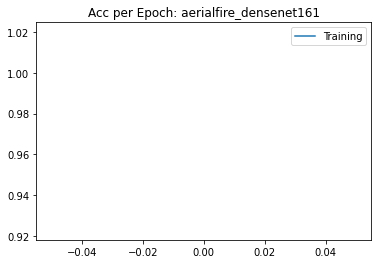

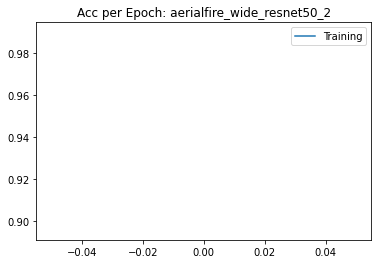

time: 3min 56s (started: 2021-11-25 17:37:11 +00:00)


In [ ]:
for i, model in enumerate(pt_models):
  if i == 1:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.fc.in_features ### Resnet Wide
    model.fc = nn.Linear(num_ftrs, 2)
  if i == 0:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.classifier.in_features ### Densenet161
    model.classifier = nn.Linear(num_ftrs, 2)
  # define loss function, optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  save_loss = {'Training':[], 'Test':[]}
  save_acc = {'Training':[], 'Test':[]}
  
  ###############
  #TRAINING LOOP#
  ###############
  model.train()
  phase = "Training"
  for epoch in range(epochs):
      model = model.to(device)
      current_loss = 0.0
      current_corrects = 0
      print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
      for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          # Time to carry out the forward training poss
          with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

          # We want variables to hold the loss/acc statistics
          current_loss += loss.item() * inputs.size(0)
          current_corrects += torch.sum(preds == labels.data)

      # saving variable for plotting
      save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

      # pretty print
      print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #save final results
  torch.save(model.state_dict(), os.path.join(PATH, model_names[i], model_names[i] + '.pt'))

  ###############
  #TESTING  LOOP#
  ###############
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  phase = "Test"
  print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
  for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
      # saving variable for plottin
      save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

  # pretty print
  print(f"Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #plot and save results
  fig = plt.figure()
  plt.plot(save_acc['Training'])
  plt.legend(["Training"])
  plt.title("Acc per Epoch: " + model_names[i])
  fig.savefig(os.path.join(PATH, model_names[i], model_names[i] + '.png'), dpi=100)

# Image Classification: Landsat-8 Imagery

## Setup

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
folder_paths = ['/content/drive/MyDrive/datasets/landsat_mini/Training/Fire', '/content/drive/MyDrive/datasets/landsat_mini/Training/No_Fire', '/content/drive/MyDrive/datasets/landsat_mini/Test/Fire', '/content/drive/MyDrive/datasets/landsat_mini/Test/No_Fire']
data = [[] for i in range(len(folder_paths))]
labels = [np.array([0]), np.array([1])]
datasets = []
dataloaders = []
file = None
err_count = 0
ok_count = 0
for i, folder_path in enumerate(folder_paths):
  for file in os.listdir(folder_path):
    try:
      # Interpret 10-band GeoTIFF using RasterIO
      file = rasterio.open(os.path.join(folder_path, file))
      file = rasterio.plot.reshape_as_image(file.read((2,6,7)))
      # resize to 256x256 using bilinear interpolation
      file = scipy.ndimage.zoom(file, (2,2,1), order=1)
      # convert to Tensor
      x = torch.from_numpy(file.astype(np.int16))
      # normalize tensor to [-1, 1]
      MEAN = x.max()-x.min() * torch.tensor([0.485, 0.456, 0.406])
      STD = x.max()-x.min() * torch.tensor([0.229, 0.224, 0.225])
      x = x.type(torch.float32)
      x = x.permute(-1, 0, 1)
      x = (x - MEAN[:, None, None]) / STD[:, None, None]
      # print(x.shape, file.shape)
      data[i].append(x)
      ok_count += 1
    except:
      err_count += 1
  if not data[i]:
    print("No data found, iteration {}".format(i))
    continue
  x_t = torch.stack(data[i])
  print(x_t.shape, data[i][0].shape)
  y_t = torch.Tensor([labels[i % 2] for j in range(len(x_t))])
  y_t = y_t.type(torch.int64)
  y_t = y_t.squeeze()
  datasets.append(TensorDataset(x_t, y_t)) # create your datset
  if i % 2 == 1:
    dsab_cat = ConcatDataset([datasets[i-1], datasets[i]])
    dataloaders.append(DataLoader(dsab_cat, batch_size=16, shuffle=(True if i < 2 else False))) # create your dataloader
    print("Dataloader appended.")
print("Process complete. Error count was {}".format(err_count))

torch.Size([242, 3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([128, 3, 256, 256]) torch.Size([3, 256, 256])
Dataloader appended.
torch.Size([213, 3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([136, 3, 256, 256]) torch.Size([3, 256, 256])
Dataloader appended.
Process complete. Error count was 1
time: 14.5 s (started: 2021-11-26 19:20:29 +00:00)


https://stackoverflow.com/questions/65621414/how-to-merge-two-torch-utils-data-dataloaders-with-a-single-operation

In [ ]:
try:
  sample = next(iter(dataloaders[0]))
  # print(sample)
  print(sample[0].shape)
  print(sample[1].shape)
  print(sample[1][1].dtype)
except:
  print("Seems there's an error with the dataloaders.")

torch.Size([16, 3, 256, 256])
torch.Size([16])
torch.int64
time: 10.5 ms (started: 2021-11-26 19:20:43 +00:00)


In [ ]:
# intialize pretrained models
pt_models = [models.wide_resnet50_2(pretrained=True), models.densenet161(pretrained=True)]
epochs = 10
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"
model_names = ["satfire_wide_resnet50_2", "satfire_densenet161"]
for i, _ in enumerate(model_names):
  if not os.path.exists(os.path.join(PATH, model_names[i])):
    os.mkdir(os.path.join(PATH, model_names[i]))

time: 1.7 s (started: 2021-11-26 19:20:43 +00:00)


Model is now satfire_wide_resnet50_2
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:0 -- Phase:0 -- Loss:nan -- Acc:64.05
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:1 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:2 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:3 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:4 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:5 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:6 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:7 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:8 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:9 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 1: 22


0it [00:00, ?it/s]

Phase:1 -- Loss:nan -- Acc:61.03
Model is now satfire_densenet161
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:0 -- Phase:0 -- Loss:nan -- Acc:69.46
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:1 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:2 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:3 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:4 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:5 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:6 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:7 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:8 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 0: 24


0it [00:00, ?it/s]

Epoch:9 -- Phase:0 -- Loss:nan -- Acc:65.41
Number of batches: 1: 22


0it [00:00, ?it/s]

RuntimeError: ignored

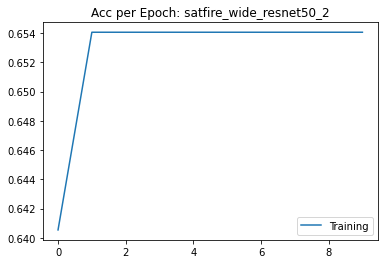

time: 2min 24s (started: 2021-11-26 19:20:45 +00:00)


In [ ]:
for i, model in enumerate(pt_models):
  if i == 0:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.fc.in_features ### Resnet Wide
    model.fc = nn.Linear(num_ftrs, 2)
  if i == 1:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.classifier.in_features ### Densenet161
    model.classifier = nn.Linear(num_ftrs, 2)
  # define loss function, optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  save_loss = {0:[], 1:[]}
  save_acc = {0:[], 1:[]}
  
  ###############
  #TRAINING LOOP#
  ###############
  model.train()
  phase = 0
  for epoch in range(epochs):
      model = model.to(device)
      current_loss = 0.0
      current_corrects = 0
      print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
      for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          # Time to carry out the forward training poss
          with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

          # We want variables to hold the loss/acc statistics
          current_loss += loss.item() * inputs.size(0)
          current_corrects += torch.sum(preds == labels.data)

      # saving variable for plotting
      save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

      # pretty print
      print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #save final results
  torch.save(model.state_dict(), os.path.join(PATH, model_names[i], model_names[i] + '.pt'))

  ###############
  #TESTING  LOOP#
  ###############
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  phase = 1
  print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
  for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
      # saving variable for plottin
      save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

  # pretty print
  print(f"Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #plot and save results
  fig = plt.figure()
  plt.plot(save_acc[0])
  plt.legend(["Training"])
  plt.title("Acc per Epoch: " + model_names[i])
  fig.savefig(os.path.join(PATH, model_names[i], model_names[i] + '.png'), dpi=100)